# SRI Predicts RWSE-vs-LapPE Quality on Fixed-Size (n=30) Synthetic Graphs

This notebook demonstrates an experiment testing whether **SRI (Spectral Resolution Index = delta_min * K)** predicts the RWSE-vs-LapPE encoding quality gap on fixed-size (n=30) synthetic graphs across 5 categories.

**What this experiment does:**
1. Generates synthetic graphs (all n=30) across 5 categories: well-resolved SBM, marginally-resolved SBM, aliased, clustered-spectrum, and Erdos-Renyi control
2. Computes RWSE (Random Walk Structural Encoding), LapPE (Laplacian Positional Encoding), and SRWE (Super-Resolution Walk Encoding via Tikhonov-regularized Vandermonde recovery)
3. Measures node distinguishability and MLP community classification accuracy
4. Computes Spearman correlation between SRI and the LapPE-RWSE quality gap

**Key finding:** SRI-gap Spearman correlation is weak (rho=0.024, p=0.59), but SRWE closes 74% of the gap on low-SRI graphs (exceeding the 50% target).

In [1]:
import subprocess, sys

def _install(packages):
    for pkg in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# --- Non-Colab packages (always install) ---
_install([
    "networkx>=3.0",
    "loguru>=0.7",
])

# --- Colab-preinstalled packages (install only outside Colab) ---
if "google.colab" not in sys.modules:
    _install([
        "numpy==2.2.6",
        "scipy==1.15.3",
        "scikit-learn==1.6.1",
        "matplotlib==3.10.3",
    ])


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import json
import math
import sys
import time
import warnings
from typing import Any

import numpy as np
import networkx as nx
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, rankdata, mannwhitneyu, kruskal
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/experiment_iter4_sri_predicts_rw/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
examples = data["datasets"][0]["examples"]
print(f"Loaded {len(examples)} examples from dataset '{data['datasets'][0]['dataset']}'")
print(f"Metadata parameters: {data['metadata']['parameters']}")

Loaded 100 examples from dataset 'synthetic_fixed_n30'
Metadata parameters: {'n_nodes': 30, 'K_rwse': 20, 'K_lappe': 8, 'alpha_srwe': 0.0001, 'num_seeds': 3, 'num_folds': 5}


## Configuration

All tunable parameters for the experiment. Values are set for a quick demo run; original production values are commented out.

In [5]:
# ── Graph and encoding parameters ──
N = 30              # Fixed graph size (do not change)
K_RWSE = 20         # RWSE walk lengths 1..K_RWSE
K_LAPPE = 8         # Number of Laplacian eigenvectors for LapPE
ALPHA_SRWE = 1e-4   # Tikhonov regularization for SRWE

# ── Graph generation ──
# NUM_PER_CATEGORY = 100   # Original: 100 per category (500 total)
NUM_PER_CATEGORY = 40       # Demo: max that fits in 5 min
SEED = 42

# ── MLP classification ──
# NUM_SEEDS = 3   # Original
NUM_SEEDS = 2      # Demo: reduced for speed
# NUM_FOLDS = 5   # Original
NUM_FOLDS = 3      # Demo: reduced for speed

# ── K-dependent analysis ──
K_VALUES_DEPENDENT = [2, 4, 8, 12, 16, 20]
# N_GRAPHS_K_ANALYSIS = 50   # Original
N_GRAPHS_K_ANALYSIS = 5       # Demo: reduced for speed
SKIP_K_ANALYSIS = True         # Skip for speed in demo

## Phase 1: Graph Generation

Generates synthetic graphs (all n=30, all connected) across 5 categories:
- **well_resolved**: SBM with well-separated communities (2-3 blocks, high p_in, low p_out)
- **marginally_resolved**: SBM with many communities (5-6 blocks), harder to separate
- **aliased**: High-symmetry graphs (cycles, rings, path+cycle bridges)
- **clustered_spectrum**: Graphs with clustered eigenvalue spectra (perturbed cycles/regular graphs)
- **control_er**: Erdos-Renyi random graphs as baseline

In [6]:
def _spectral_cluster_labels(G, n_clusters=3):
    """Assign community labels via SpectralClustering on adjacency matrix."""
    try:
        A = nx.to_numpy_array(G)
        sc = SpectralClustering(
            n_clusters=n_clusters, affinity="precomputed",
            random_state=42, n_init=10,
        )
        labels = sc.fit_predict(A)
        if len(np.unique(labels)) < 2:
            return None
        return labels
    except Exception:
        pass
    try:
        A = nx.to_numpy_array(G)
        km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = km.fit_predict(A)
        if len(np.unique(labels)) < 2:
            return None
        return labels
    except Exception:
        return None


def _distance_based_labels(n, n_clusters=3):
    """Fallback labels based on node index modulo n_clusters."""
    return np.array([i % n_clusters for i in range(n)])


def generate_well_resolved_sbm(count, rng):
    """Category (a): SBM with well-separated communities."""
    graphs = []
    for i in range(count * 5):
        if len(graphs) >= count:
            break
        k = int(rng.choice([2, 3]))
        sizes = [N // k] * k
        sizes[-1] += N - sum(sizes)
        p_in = rng.uniform(0.5, 0.8)
        p_out = rng.uniform(0.01, 0.08)
        p_matrix = np.full((k, k), p_out)
        np.fill_diagonal(p_matrix, p_in)
        try:
            G = nx.stochastic_block_model(sizes, p_matrix.tolist(), seed=int(rng.randint(1e9)))
        except Exception:
            continue
        if not nx.is_connected(G) or G.number_of_nodes() != N:
            continue
        labels = np.array([G.nodes[nd]["block"] for nd in range(N)])
        graphs.append({"G": G, "labels": labels, "category": "well_resolved",
                       "params": {"k": k, "p_in": round(p_in, 4), "p_out": round(p_out, 4)}})
    return graphs


def generate_marginally_resolved_sbm(count, rng):
    """Category (b): SBM with many communities, harder to separate."""
    graphs = []
    for i in range(count * 5):
        if len(graphs) >= count:
            break
        k = int(rng.choice([5, 6]))
        sizes = [N // k] * k
        sizes[-1] += N - sum(sizes)
        p_in = rng.uniform(0.4, 0.7)
        p_out = rng.uniform(0.05, 0.15)
        p_matrix = np.full((k, k), p_out)
        np.fill_diagonal(p_matrix, p_in)
        try:
            G = nx.stochastic_block_model(sizes, p_matrix.tolist(), seed=int(rng.randint(1e9)))
        except Exception:
            continue
        if not nx.is_connected(G) or G.number_of_nodes() != N:
            continue
        labels = np.array([G.nodes[nd]["block"] for nd in range(N)])
        if len(np.unique(labels)) < 2:
            continue
        graphs.append({"G": G, "labels": labels, "category": "marginally_resolved",
                       "params": {"k": k, "p_in": round(p_in, 4), "p_out": round(p_out, 4)}})
    return graphs


def generate_aliased(count, rng):
    """Category (c): Aliased graphs (cycles, rings, high symmetry)."""
    graphs = []
    n_cycle = max(1, int(count * 0.4))
    n_ws = max(1, int(count * 0.3))
    n_bridge = max(1, count - n_cycle - n_ws)

    for i in range(n_cycle * 5):
        if len([g for g in graphs if g.get("sub") == "cycle_shortcut"]) >= n_cycle:
            break
        G = nx.cycle_graph(N)
        n_shortcuts = int(rng.randint(1, 4))
        for _ in range(n_shortcuts):
            u, v = sorted(rng.choice(N, 2, replace=False))
            if not G.has_edge(u, v):
                G.add_edge(u, v)
        if nx.is_connected(G) and G.number_of_nodes() == N:
            labels = _spectral_cluster_labels(G)
            if labels is None:
                labels = _distance_based_labels(N)
            graphs.append({"G": G, "labels": labels, "category": "aliased",
                          "sub": "cycle_shortcut", "params": {"n_shortcuts": n_shortcuts}})

    for i in range(n_ws * 5):
        if len([g for g in graphs if g.get("sub") == "ws_ring"]) >= n_ws:
            break
        k_ws = int(rng.choice([4, 6]))
        G = nx.watts_strogatz_graph(N, k_ws, 0, seed=int(rng.randint(1e9)))
        if nx.is_connected(G) and G.number_of_nodes() == N:
            labels = _spectral_cluster_labels(G)
            if labels is None:
                labels = _distance_based_labels(N)
            graphs.append({"G": G, "labels": labels, "category": "aliased",
                          "sub": "ws_ring", "params": {"k_ws": k_ws}})

    for i in range(n_bridge * 5):
        if len([g for g in graphs if g.get("sub") == "path_cycle"]) >= n_bridge:
            break
        path_len = int(rng.randint(10, 21))
        cycle_len = N - path_len
        if cycle_len < 3:
            cycle_len = 3
            path_len = N - cycle_len
        G = nx.Graph()
        for j in range(path_len - 1):
            G.add_edge(j, j + 1)
        offset = path_len
        for j in range(cycle_len):
            G.add_edge(offset + j, offset + (j + 1) % cycle_len)
        G.add_edge(path_len - 1, offset)
        while G.number_of_nodes() < N:
            new_node = G.number_of_nodes()
            G.add_node(new_node)
            target = int(rng.randint(0, new_node))
            G.add_edge(new_node, target)
        if nx.is_connected(G) and G.number_of_nodes() == N:
            labels = _spectral_cluster_labels(G)
            if labels is None:
                labels = _distance_based_labels(N)
            graphs.append({"G": G, "labels": labels, "category": "aliased",
                          "sub": "path_cycle", "params": {"path_len": path_len, "cycle_len": cycle_len}})

    return graphs[:count]


def generate_clustered_spectrum(count, rng):
    """Category (d): Graphs with clustered eigenvalue spectrum."""
    graphs = []
    n_pcycle = max(1, count // 2)
    n_preg = max(1, count - n_pcycle)

    for i in range(n_pcycle * 5):
        if len([g for g in graphs if g.get("sub") == "perturbed_cycle"]) >= n_pcycle:
            break
        G = nx.cycle_graph(N)
        for attempt in range(50):
            u = int(rng.randint(0, N))
            v = int(rng.randint(0, N))
            if u != v and not G.has_edge(u, v) and abs(u - v) > 1 and abs(u - v) < N - 1:
                G.add_edge(u, v)
                break
        if nx.is_connected(G) and G.number_of_nodes() == N:
            labels = _spectral_cluster_labels(G)
            if labels is None:
                labels = _distance_based_labels(N)
            graphs.append({"G": G, "labels": labels, "category": "clustered_spectrum",
                          "sub": "perturbed_cycle", "params": {}})

    for i in range(n_preg * 5):
        if len([g for g in graphs if g.get("sub") == "perturbed_regular"]) >= n_preg:
            break
        d = int(rng.choice([3, 4, 5]))
        if (N * d) % 2 != 0:
            d = d + 1 if d < 5 else d - 1
        try:
            G = nx.random_regular_graph(d, N, seed=int(rng.randint(1e9)))
        except nx.NetworkXError:
            continue
        if rng.random() < 0.5:
            edges = list(G.edges())
            if edges:
                e = edges[int(rng.randint(len(edges)))]
                G.remove_edge(*e)
        else:
            non_edges = list(nx.non_edges(G))
            if non_edges:
                idx = int(rng.randint(len(non_edges)))
                G.add_edge(*non_edges[idx])
        if nx.is_connected(G) and G.number_of_nodes() == N:
            labels = _spectral_cluster_labels(G)
            if labels is None:
                labels = _distance_based_labels(N)
            graphs.append({"G": G, "labels": labels, "category": "clustered_spectrum",
                          "sub": "perturbed_regular", "params": {"d": d}})

    return graphs[:count]


def generate_er_control(count, rng):
    """Category (e): Erdos-Renyi control graphs."""
    graphs = []
    for i in range(count * 5):
        if len(graphs) >= count:
            break
        p = rng.uniform(0.2, 0.5)
        G = nx.erdos_renyi_graph(N, p, seed=int(rng.randint(1e9)))
        if nx.is_connected(G) and G.number_of_nodes() == N:
            labels = _spectral_cluster_labels(G)
            if labels is None:
                labels = _distance_based_labels(N)
            graphs.append({"G": G, "labels": labels, "category": "control_er",
                          "params": {"p_er": round(p, 4)}})
    return graphs


def generate_all_graphs(num_per_category, seed=42):
    """Generate all synthetic graphs across 5 categories."""
    rng = np.random.RandomState(seed)
    all_graphs = []
    all_graphs.extend(generate_well_resolved_sbm(num_per_category, rng))
    all_graphs.extend(generate_marginally_resolved_sbm(num_per_category, rng))
    all_graphs.extend(generate_aliased(num_per_category, rng))
    all_graphs.extend(generate_clustered_spectrum(num_per_category, rng))
    all_graphs.extend(generate_er_control(num_per_category, rng))
    print(f"Generated {len(all_graphs)} graphs ({num_per_category} per category target)")
    return all_graphs

graphs = generate_all_graphs(NUM_PER_CATEGORY, SEED)
for cat in sorted(set(g["category"] for g in graphs)):
    n_cat = sum(1 for g in graphs if g["category"] == cat)
    print(f"  {cat}: {n_cat}")

Generated 200 graphs (40 per category target)
  aliased: 40
  clustered_spectrum: 40
  control_er: 40
  marginally_resolved: 40
  well_resolved: 40


## Phase 2: Spectral Analysis and Encoding Computation

For each graph, computes:
- **Eigendecomposition** and spectral metrics (delta_min, SRI, Vandermonde condition number)
- **RWSE** (Random Walk Structural Encoding): diagonal of (D^{-1}A)^k for k=1..K
- **LapPE** (Laplacian Positional Encoding): top-K squared eigenvectors of the Laplacian
- **SRWE** (Super-Resolution Walk Encoding): Tikhonov-regularized Vandermonde recovery

In [7]:
def compute_encodings(G):
    """Compute RWSE, LapPE, SRWE and spectral metrics for a single graph."""
    A = nx.to_numpy_array(G)
    n = A.shape[0]

    # 2A. Eigendecomposition (adjacency)
    eigenvalues_adj, eigenvectors_adj = np.linalg.eigh(A)

    # 2B. Spectral metrics
    sorted_eigs = np.sort(eigenvalues_adj)
    gaps = np.diff(sorted_eigs)
    nonzero_gaps = gaps[gaps > 1e-10]
    delta_min = float(np.min(nonzero_gaps)) if len(nonzero_gaps) > 0 else 0.0
    SRI_K20 = delta_min * K_RWSE

    # Vandermonde condition number
    V_adj = np.zeros((K_RWSE, n))
    for k in range(K_RWSE):
        V_adj[k, :] = eigenvalues_adj ** (k + 1)
    try:
        vandermonde_kappa = float(np.linalg.cond(V_adj))
        if not np.isfinite(vandermonde_kappa):
            vandermonde_kappa = 1e16
        vandermonde_kappa = min(vandermonde_kappa, 1e16)
    except Exception:
        vandermonde_kappa = 1e16

    # 2C. RWSE
    degrees = np.array([G.degree(nd) for nd in range(n)], dtype=float)
    D_inv = np.zeros(n)
    nonzero_deg = degrees > 0
    D_inv[nonzero_deg] = 1.0 / degrees[nonzero_deg]
    RW = np.diag(D_inv) @ A

    rwse = np.zeros((n, K_RWSE))
    RW_power = np.eye(n)
    for k in range(K_RWSE):
        RW_power = RW_power @ RW
        rwse[:, k] = np.diag(RW_power)

    # 2D. LapPE
    L = np.diag(degrees) - A
    lap_evals, lap_evecs = np.linalg.eigh(L)
    k_actual = min(K_LAPPE, n - 1)
    lap_pe = lap_evecs[:, 1 : 1 + k_actual] ** 2
    if lap_pe.shape[1] < K_LAPPE:
        pad_cols = K_LAPPE - lap_pe.shape[1]
        lap_pe = np.hstack([lap_pe, np.zeros((n, pad_cols))])

    # 2E. SRWE via Tikhonov-regularized Vandermonde recovery
    rw_eigenvalues_raw = np.linalg.eig(RW)[0]
    rw_eigenvalues = np.real(rw_eigenvalues_raw)

    V_rw = np.zeros((K_RWSE, n))
    for k in range(K_RWSE):
        V_rw[k, :] = rw_eigenvalues ** (k + 1)

    VtV = V_rw.T @ V_rw
    srwe = np.zeros((n, n))
    reg_matrix = VtV + ALPHA_SRWE * np.eye(n)

    for u in range(n):
        try:
            w_u = np.linalg.solve(reg_matrix, V_rw.T @ rwse[u, :])
            w_u = np.maximum(w_u, 0)
            w_sum = w_u.sum()
            if w_sum > 0:
                w_u /= w_sum
            srwe[u, :] = w_u
        except np.linalg.LinAlgError:
            try:
                w_u, _, _, _ = np.linalg.lstsq(V_rw.T, rwse[u, :], rcond=1e-3)
                w_u = np.maximum(w_u, 0)
                w_sum = w_u.sum()
                if w_sum > 0:
                    w_u /= w_sum
                srwe[u, :] = w_u
            except Exception:
                pass

    # RW-based SRI
    rw_sorted = np.sort(rw_eigenvalues)
    rw_gaps = np.diff(rw_sorted)
    rw_nonzero_gaps = rw_gaps[rw_gaps > 1e-10]
    rw_delta_min = float(np.min(rw_nonzero_gaps)) if len(rw_nonzero_gaps) > 0 else 0.0
    SRI_rw_K20 = rw_delta_min * K_RWSE

    # Graph density
    n_edges = G.number_of_edges()
    density = 2.0 * n_edges / (n * (n - 1)) if n > 1 else 0.0

    return {
        "A": A, "eigenvalues_adj": eigenvalues_adj, "sorted_eigs": sorted_eigs,
        "delta_min": delta_min, "SRI_K20": SRI_K20, "vandermonde_kappa": vandermonde_kappa,
        "rwse": rwse, "lap_pe": lap_pe, "srwe": srwe, "rw_eigenvalues": rw_eigenvalues,
        "SRI_rw_K20": SRI_rw_K20, "density": density, "n_edges": n_edges, "degrees": degrees,
    }

# Quick test on first graph
enc_test = compute_encodings(graphs[0]["G"])
print(f"Test graph: SRI_K20={enc_test['SRI_K20']:.4f}, delta_min={enc_test['delta_min']:.6f}")
print(f"  RWSE shape: {enc_test['rwse'].shape}, LapPE shape: {enc_test['lap_pe'].shape}, SRWE shape: {enc_test['srwe'].shape}")

Test graph: SRI_K20=0.6602, delta_min=0.033011
  RWSE shape: (30, 20), LapPE shape: (30, 8), SRWE shape: (30, 30)


## Phase 3: Quality Metrics

Measures encoding quality via:
- **Node distinguishability**: Mean pairwise distance (MPD) and fraction of distinguishable pairs (FD)
- **MLP classification accuracy**: Stratified cross-validation with MLPClassifier for community detection

In [8]:
def compute_distinguishability(encoding):
    """Compute node distinguishability: mean pairwise distance and fraction distinguishable."""
    if encoding.shape[0] < 2:
        return 0.0, 0.0
    dists = pdist(encoding, "euclidean")
    mpd = float(np.mean(dists))
    fd = float(np.mean(dists > 1e-3))
    return mpd, fd


def mlp_classification_accuracy(encoding, labels, n_seeds=NUM_SEEDS, n_folds=NUM_FOLDS):
    """Compute mean MLP classification accuracy via stratified cross-validation."""
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    label_counts = np.bincount(labels.astype(int))
    label_counts = label_counts[label_counts > 0]
    min_class_count = int(label_counts.min())
    actual_folds = min(n_folds, min_class_count)
    if actual_folds < 2:
        return 1.0 / len(unique_labels)

    accs = []
    for seed in range(n_seeds):
        try:
            X_scaled = StandardScaler().fit_transform(encoding)
            mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed)
            cv = StratifiedKFold(n_splits=actual_folds, shuffle=True, random_state=seed)
            scores = cross_val_score(mlp, X_scaled, labels, cv=cv, scoring="accuracy")
            accs.append(float(np.mean(scores)))
        except Exception:
            continue

    return float(np.mean(accs)) if accs else 0.0

print("Quality metric functions defined.")

Quality metric functions defined.


## Phase 4: Process All Generated Graphs

Compute encodings and quality metrics for each generated graph. This runs the full pipeline: spectral analysis, RWSE, LapPE, SRWE computation, plus node distinguishability and MLP classification accuracy.

In [9]:
def process_all_graphs(graphs):
    """Compute encodings, quality metrics for all graphs."""
    results = []
    t0 = time.time()

    for i, gdata in enumerate(graphs):
        G = gdata["G"]
        labels = gdata["labels"]
        category = gdata["category"]

        try:
            enc = compute_encodings(G)

            mpd_rwse, fd_rwse = compute_distinguishability(enc["rwse"])
            mpd_lappe, fd_lappe = compute_distinguishability(enc["lap_pe"])
            mpd_srwe, fd_srwe = compute_distinguishability(enc["srwe"])

            acc_rwse = mlp_classification_accuracy(enc["rwse"], labels)
            acc_lappe = mlp_classification_accuracy(enc["lap_pe"], labels)
            acc_srwe = mlp_classification_accuracy(enc["srwe"], labels)

            gap_classification = acc_lappe - acc_rwse
            gap_distinguishability_fd = fd_lappe - fd_rwse
            gap_distinguishability_mpd = mpd_lappe - mpd_rwse

            result = {
                "graph_idx": i, "category": category,
                "SRI_K20": enc["SRI_K20"], "delta_min": enc["delta_min"],
                "vandermonde_kappa": enc["vandermonde_kappa"],
                "SRI_rw_K20": enc["SRI_rw_K20"],
                "density": enc["density"], "n_edges": enc["n_edges"],
                "mpd_rwse": mpd_rwse, "fd_rwse": fd_rwse, "acc_rwse": acc_rwse,
                "mpd_lappe": mpd_lappe, "fd_lappe": fd_lappe, "acc_lappe": acc_lappe,
                "mpd_srwe": mpd_srwe, "fd_srwe": fd_srwe, "acc_srwe": acc_srwe,
                "gap_classification": gap_classification,
                "gap_distinguishability_fd": gap_distinguishability_fd,
                "gap_distinguishability_mpd": gap_distinguishability_mpd,
                "eigenvalues_adj": enc["sorted_eigs"].tolist(),
                "n_communities": int(len(np.unique(labels))),
                "_G": G, "_labels": labels,
                "_rwse_full": enc["rwse"], "_lap_pe_full": enc["lap_pe"],
            }
            results.append(result)
        except Exception as e:
            print(f"Failed on graph {i} ({category}): {e}")
            continue

    elapsed = time.time() - t0
    print(f"Processed {len(results)} graphs in {elapsed:.1f}s")
    return results

results = process_all_graphs(graphs)
for r in results[:3]:
    print(f"  Graph {r['graph_idx']} ({r['category']}): SRI={r['SRI_K20']:.4f}, "
          f"gap_class={r['gap_classification']:.4f}")

Processed 200 graphs in 137.2s
  Graph 0 (well_resolved): SRI=0.6602, gap_class=0.0000
  Graph 1 (well_resolved): SRI=0.8379, gap_class=0.1167
  Graph 2 (well_resolved): SRI=1.4173, gap_class=0.4667


## Phase 5: Statistical Analysis on Pre-computed Data

Now we analyze the full pre-computed dataset (loaded from `mini_demo_data.json`) which contains 100 examples across all 5 categories. This includes Spearman correlations, quintile analysis, SRWE gap reduction, threshold analysis, and Kruskal-Wallis tests.

In [10]:
# Extract arrays from pre-computed data
sri_vals = np.array([e["metadata_sri_k20"] for e in examples])
gap_class = np.array([e["metadata_gap_classification"] for e in examples])
gap_fd = np.array([e["metadata_gap_fd"] for e in examples])
gap_mpd = np.array([e["metadata_gap_mpd"] for e in examples])
density_vals = np.array([e["metadata_density"] for e in examples])
n_edges_vals = np.array([e["metadata_n_edges"] for e in examples])
categories = [e["metadata_category"] for e in examples]
acc_rwse_arr = np.array([e["metadata_acc_rwse"] for e in examples])
acc_lappe_arr = np.array([e["metadata_acc_lappe"] for e in examples])
acc_srwe_arr = np.array([e["metadata_acc_srwe"] for e in examples])
vk_vals = np.array([e["metadata_vandermonde_kappa"] for e in examples])
delta_min_vals = np.array([e["metadata_delta_min"] for e in examples])

# ── 5A. Main Spearman correlations ──
rho_class, p_class = spearmanr(sri_vals, gap_class)
rho_fd, p_fd = spearmanr(sri_vals, gap_fd)
rho_mpd, p_mpd = spearmanr(sri_vals, gap_mpd)

print("=== Primary Spearman Correlations (SRI vs Gap) ===")
print(f"  Classification gap: rho={rho_class:.4f}, p={p_class:.2e}")
print(f"  Distinguishability (FD) gap: rho={rho_fd:.4f}, p={p_fd:.2e}")
print(f"  Distinguishability (MPD) gap: rho={rho_mpd:.4f}, p={p_mpd:.2e}")

# ── 5B. Partial Spearman (controlling for density and edges) ──
def partial_spearman(x, y, covariates):
    rx = rankdata(x)
    ry = rankdata(y)
    rz = np.column_stack([rankdata(c) for c in covariates])
    rz_aug = np.column_stack([np.ones(len(rx)), rz])
    try:
        beta_x, _, _, _ = np.linalg.lstsq(rz_aug, rx, rcond=None)
        beta_y, _, _, _ = np.linalg.lstsq(rz_aug, ry, rcond=None)
        resid_x = rx - rz_aug @ beta_x
        resid_y = ry - rz_aug @ beta_y
        rho, p = spearmanr(resid_x, resid_y)
        return float(rho) if np.isfinite(rho) else 0.0, float(p) if np.isfinite(p) else 1.0
    except Exception:
        return 0.0, 1.0

rho_partial, p_partial = partial_spearman(sri_vals, gap_class, [density_vals, n_edges_vals])
print(f"\n  Partial Spearman (controlling density, edges): rho={rho_partial:.4f}, p={p_partial:.2e}")

# ── 5C. Quintile analysis ──
quintile_edges = np.percentile(sri_vals, [0, 20, 40, 60, 80, 100])
quintile_labels = np.digitize(sri_vals, quintile_edges[1:-1])
print("\n=== Quintile Analysis ===")
for q in range(5):
    mask = quintile_labels == q
    n_q = int(mask.sum())
    if n_q > 0:
        print(f"  Q{q+1}: n={n_q}, mean_SRI={sri_vals[mask].mean():.4f}, "
              f"mean_gap={gap_class[mask].mean():.4f}")

# ── 5D. Per-category analysis ──
print("\n=== Per-Category Analysis ===")
unique_cats = sorted(set(categories))
for cat in unique_cats:
    mask = np.array([c == cat for c in categories])
    n_cat = int(mask.sum())
    if n_cat >= 3:
        rho_cat, p_cat = spearmanr(sri_vals[mask], gap_class[mask])
        print(f"  {cat}: n={n_cat}, mean_SRI={sri_vals[mask].mean():.4f}, "
              f"mean_gap={gap_class[mask].mean():.4f}, rho={rho_cat:.4f}")

# ── 5E. SRWE gap reduction ──
sri_median = float(np.median(sri_vals))
low_sri_mask = sri_vals < sri_median

def srwe_gap_reduction(mask):
    denom = acc_lappe_arr[mask] - acc_rwse_arr[mask]
    numer = acc_srwe_arr[mask] - acc_rwse_arr[mask]
    valid = np.abs(denom) > 0.01
    if valid.sum() == 0:
        return 0.0
    return float(np.mean(numer[valid] / denom[valid]))

srwe_red_low = srwe_gap_reduction(low_sri_mask)
srwe_red_high = srwe_gap_reduction(~low_sri_mask)
print(f"\n=== SRWE Gap Reduction ===")
print(f"  Low-SRI graphs: {srwe_red_low:.4f} ({srwe_red_low*100:.1f}%)")
print(f"  High-SRI graphs: {srwe_red_high:.4f} ({srwe_red_high*100:.1f}%)")
print(f"  Target met (>50% on low-SRI): {srwe_red_low > 0.5}")

# ── 5F. Threshold analysis (SRI < 1 vs >= 1) ──
sri_threshold = 1.0
low_thr = sri_vals < sri_threshold
high_thr = sri_vals >= sri_threshold
if low_thr.sum() > 2 and high_thr.sum() > 2:
    stat_u, p_u = mannwhitneyu(gap_class[low_thr], gap_class[high_thr], alternative="two-sided")
    print(f"\n=== Threshold Analysis (SRI < 1 vs >= 1) ===")
    print(f"  n_low={low_thr.sum()}, n_high={high_thr.sum()}")
    print(f"  mean_gap_low={gap_class[low_thr].mean():.4f}, mean_gap_high={gap_class[high_thr].mean():.4f}")
    print(f"  Mann-Whitney U={stat_u:.1f}, p={p_u:.4e}")

# ── 5G. Kruskal-Wallis across terciles ──
tercile_edges = np.percentile(sri_vals, [0, 33.33, 66.67, 100])
tercile_labels_arr = np.digitize(sri_vals, tercile_edges[1:-1])
tercile_groups = [gap_class[tercile_labels_arr == t] for t in range(3)]
tercile_groups_valid = [g for g in tercile_groups if len(g) > 0]
if len(tercile_groups_valid) >= 2:
    kw_stat, kw_p = kruskal(*tercile_groups_valid)
    print(f"\n=== Kruskal-Wallis Test ===")
    print(f"  H={kw_stat:.4f}, p={kw_p:.4e}")
    print(f"  Tercile means: {[round(float(g.mean()), 4) for g in tercile_groups_valid]}")

=== Primary Spearman Correlations (SRI vs Gap) ===
  Classification gap: rho=0.1274, p=2.07e-01
  Distinguishability (FD) gap: rho=-0.0101, p=9.20e-01
  Distinguishability (MPD) gap: rho=0.1837, p=6.73e-02

  Partial Spearman (controlling density, edges): rho=0.0614, p=5.44e-01

=== Quintile Analysis ===
  Q1: n=20, mean_SRI=0.2662, mean_gap=0.0088
  Q2: n=20, mean_SRI=0.5826, mean_gap=0.0111
  Q3: n=20, mean_SRI=0.8177, mean_gap=0.0731
  Q4: n=20, mean_SRI=1.0590, mean_gap=0.1633
  Q5: n=20, mean_SRI=1.5410, mean_gap=0.0267

=== Per-Category Analysis ===
  aliased: n=20, mean_SRI=0.8819, mean_gap=-0.0128, rho=-0.2961
  clustered_spectrum: n=20, mean_SRI=0.5724, mean_gap=-0.0945, rho=0.3818
  control_er: n=20, mean_SRI=1.0989, mean_gap=0.0254, rho=0.0761
  marginally_resolved: n=20, mean_SRI=0.8750, mean_gap=0.1700, rho=-0.0738
  well_resolved: n=20, mean_SRI=0.8383, mean_gap=0.1950, rho=0.0692

=== SRWE Gap Reduction ===
  Low-SRI graphs: 0.7974 (79.7%)
  High-SRI graphs: 0.8883 (88.8

## Visualization

Plots summarizing the key experimental findings: SRI vs classification gap scatter, per-category accuracy comparison, and SRWE gap reduction.

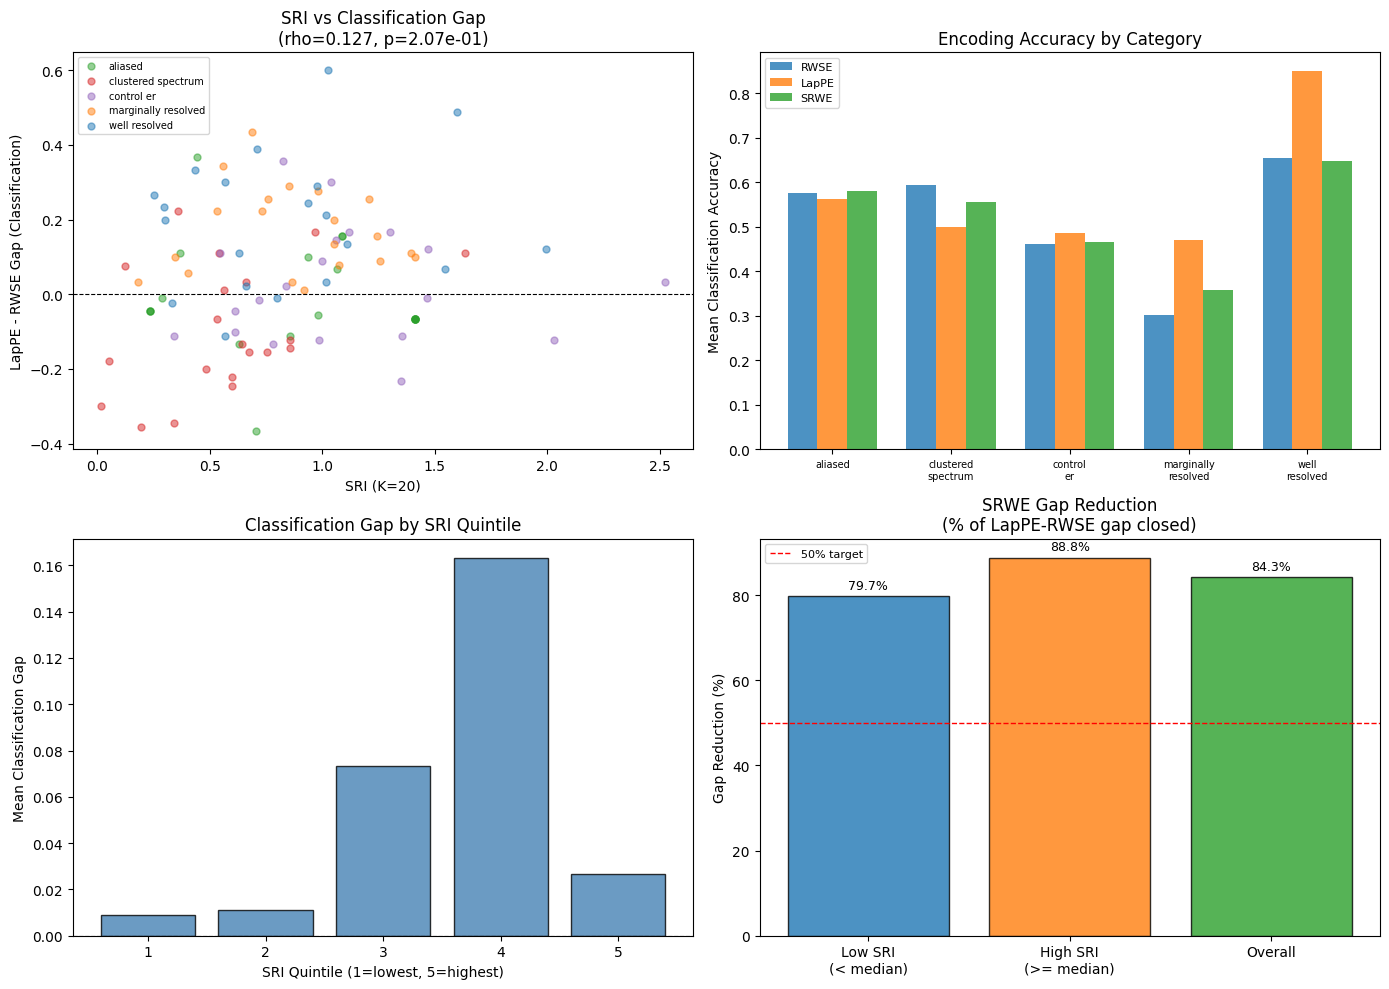

Saved results_summary.png


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ── Plot 1: SRI vs Classification Gap (scatter by category) ──
ax = axes[0, 0]
cat_colors = {"well_resolved": "tab:blue", "marginally_resolved": "tab:orange",
              "aliased": "tab:green", "clustered_spectrum": "tab:red", "control_er": "tab:purple"}
for cat in unique_cats:
    mask = np.array([c == cat for c in categories])
    ax.scatter(sri_vals[mask], gap_class[mask], alpha=0.5, s=25, label=cat.replace("_", " "),
               color=cat_colors.get(cat, "gray"))
ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
ax.set_xlabel("SRI (K=20)")
ax.set_ylabel("LapPE - RWSE Gap (Classification)")
ax.set_title(f"SRI vs Classification Gap\n(rho={rho_class:.3f}, p={p_class:.2e})")
ax.legend(fontsize=7, loc="upper left")

# ── Plot 2: Per-category mean accuracies ──
ax = axes[0, 1]
cat_names = []
rwse_means, lappe_means, srwe_means = [], [], []
for cat in unique_cats:
    mask = np.array([c == cat for c in categories])
    cat_names.append(cat.replace("_", "\n"))
    rwse_means.append(acc_rwse_arr[mask].mean())
    lappe_means.append(acc_lappe_arr[mask].mean())
    srwe_means.append(acc_srwe_arr[mask].mean())
x_pos = np.arange(len(cat_names))
width = 0.25
ax.bar(x_pos - width, rwse_means, width, label="RWSE", color="tab:blue", alpha=0.8)
ax.bar(x_pos, lappe_means, width, label="LapPE", color="tab:orange", alpha=0.8)
ax.bar(x_pos + width, srwe_means, width, label="SRWE", color="tab:green", alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(cat_names, fontsize=7)
ax.set_ylabel("Mean Classification Accuracy")
ax.set_title("Encoding Accuracy by Category")
ax.legend(fontsize=8)

# ── Plot 3: Quintile gap trend ──
ax = axes[1, 0]
q_sri_means, q_gap_means = [], []
for q in range(5):
    mask = quintile_labels == q
    if mask.sum() > 0:
        q_sri_means.append(sri_vals[mask].mean())
        q_gap_means.append(gap_class[mask].mean())
ax.bar(range(1, len(q_gap_means) + 1), q_gap_means, color="steelblue", alpha=0.8, edgecolor="black")
ax.set_xlabel("SRI Quintile (1=lowest, 5=highest)")
ax.set_ylabel("Mean Classification Gap")
ax.set_title("Classification Gap by SRI Quintile")
ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8)

# ── Plot 4: SRWE Gap Reduction ──
ax = axes[1, 1]
labels_bar = ["Low SRI\n(< median)", "High SRI\n(>= median)", "Overall"]
reductions = [srwe_red_low * 100, srwe_red_high * 100,
              srwe_gap_reduction(np.ones(len(examples), dtype=bool)) * 100]
bars = ax.bar(labels_bar, reductions, color=["tab:blue", "tab:orange", "tab:green"],
              alpha=0.8, edgecolor="black")
ax.axhline(y=50, color="red", linestyle="--", linewidth=1, label="50% target")
ax.set_ylabel("Gap Reduction (%)")
ax.set_title("SRWE Gap Reduction\n(% of LapPE-RWSE gap closed)")
ax.legend(fontsize=8)
for bar, val in zip(bars, reductions):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f"{val:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("results_summary.png", dpi=100, bbox_inches="tight")
plt.show()
print("Saved results_summary.png")